# MVAY Final Project

## Introduction

In this final project we will build our own stochastic public transport route planner to improve on the problematic of route planning with travel time uncertainty. We are supposed to reuse the SBB dataset. The route planner can be build on a set of simplifying assumptions and has to meet the constraints of shortest travel time, user-defined certainty level and latest initial route departure time.

The structure of this notebook, and the decomposition into smaller tasks, is the following:

- *Data wrangling:* in this section, we are doing basic filtering for data that meets the constraints given by the project 
(business hours, 15km radius etc.).
                   
- *Timetable definition*: this part incorporates the creation of a lookup table (timetable) with distinct trip_id's that      represent the transportation network.

- *Graph creation*: we can now build a connected graph of nodes and edges (stops and connections) with the timetable, this will serve as a base for the routing  algorithm.

- *Modified Dijkstra*: we use a modified version of the Dijkstra algorithm combined with Yen's algorithm to search for n-shortest paths on the created graph given an user query.

- *Predictive modeling*: this part incorporates the descriptive and inferential statistics calculation of the delay parameter, which can be used for route certainty definition.

- *Route probability*: with a given set of short routes, and delay distributions on various groupings, we  calculate certainties of whole routes by a sequential sum product of stop certainties.

- *Validation and Discussion*: we test and discuss the assumptions/groupings we have made during the whole assignment. We also highlight strenghts and weaknesses of our implementation.

In [1]:
%%configure
{"conf": {
    "spark.app.name": "MVAY_final"
}}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
9112,application_1589299642358_3675,pyspark,idle,Link,Link,
9130,application_1589299642358_3694,pyspark,busy,Link,Link,
9145,application_1589299642358_3710,pyspark,idle,Link,Link,
9171,application_1589299642358_3738,pyspark,idle,Link,Link,
9176,application_1589299642358_3743,pyspark,busy,Link,Link,
9177,application_1589299642358_3744,pyspark,idle,Link,Link,
9180,application_1589299642358_3747,pyspark,idle,Link,Link,
9181,application_1589299642358_3748,pyspark,idle,Link,Link,
9182,application_1589299642358_3749,pyspark,busy,Link,Link,
9183,application_1589299642358_3750,pyspark,idle,Link,Link,


### Start Spark

In [2]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
8901,application_1589299642358_3433,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [1]:
# Import packages
import math
import pandas as pd
import pyspark.sql.functions as f
from pyspark.sql.types import FloatType, IntegerType
import time, datetime
import heapq
import scipy.stats

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
9463,application_1589299642358_4053,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Load necessary data

Load the `stop_times` dataframe which includes the trips.

In [2]:
stop_times = spark.read.orc("/data/sbb/timetables/orc/stop_times/")
stop_times.show(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------+-----------+-------------+-----------+-------------+
|             trip_id|arrival_time|departure_time|    stop_id|stop_sequence|pickup_type|drop_off_type|
+--------------------+------------+--------------+-----------+-------------+-----------+-------------+
|1.TA.1-1-B-j19-1.1.R|    04:20:00|      04:20:00|8500010:0:3|            1|          0|            0|
|1.TA.1-1-B-j19-1.1.R|    04:24:00|      04:24:00|8500020:0:3|            2|          0|            0|
+--------------------+------------+--------------+-----------+-------------+-----------+-------------+
only showing top 2 rows

Load the `stops` dataframe which includes the stops and their coordinates.

In [3]:
stops = spark.read.orc("/data/sbb/timetables/orc/stops/") 
stops.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+----------------+----------------+-------------+--------------+
|stop_id|   stop_name|        stop_lat|        stop_lon|location_type|parent_station|
+-------+------------+----------------+----------------+-------------+--------------+
|1322000|    Altoggio|46.1672513851495|  8.345807131427|             |              |
|1322001|Antronapiana| 46.060121674738|8.11361957990831|             |              |
|1322002|      Anzola|45.9898698225697|8.34571729989858|             |              |
+-------+------------+----------------+----------------+-------------+--------------+
only showing top 3 rows

Load the `calendar`  dataframe which includes the schedule for the routes.

In [4]:
calendar = spark.read.orc("/data/sbb/timetables/orc/calendar/") 
calendar.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+-------+---------+--------+------+--------+------+
|service_id|monday|tuesday|wednesday|thursday|friday|saturday|sunday|
+----------+------+-------+---------+--------+------+--------+------+
|  TA+b0nx9|  true|   true|     true|    true|  true|   false| false|
|  TA+b03bf|  true|   true|     true|    true|  true|   false| false|
|  TA+b0008|  true|   true|     true|    true|  true|   false| false|
+----------+------+-------+---------+--------+------+--------+------+
only showing top 3 rows

Load the `trips` dataframe needed for retrieving the calendar for different trips.

In [5]:
trips = spark.read.orc("/data/sbb/timetables/orc/trips/") 
trips.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+--------------------+------------------+---------------+------------+
|   route_id|service_id|             trip_id|     trip_headsign|trip_short_name|direction_id|
+-----------+----------+--------------------+------------------+---------------+------------+
|1-1-C-j19-1|  TA+b0001|5.TA.1-1-C-j19-1.3.R|Zofingen, Altachen|            108|           1|
|1-1-C-j19-1|  TA+b0001|7.TA.1-1-C-j19-1.3.R|Zofingen, Altachen|            112|           1|
|1-1-C-j19-1|  TA+b0001|9.TA.1-1-C-j19-1.3.R|Zofingen, Altachen|            116|           1|
+-----------+----------+--------------------+------------------+---------------+------------+
only showing top 3 rows

Load the `routes` dataframe in order to be able to retrieve the transportation type.

In [6]:
routes =  spark.read.orc("/data/sbb/timetables/orc/routes/") 
routes.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+---------+----------------+---------------+----------+----------+
|   route_id|agency_id|route_short_name|route_long_name|route_desc|route_type|
+-----------+---------+----------------+---------------+----------+----------+
|11-40-j19-1|      801|             040|               |       Bus|       700|
|11-61-j19-1|     7031|             061|               |       Bus|       700|
|11-62-j19-1|     7031|             062|               |       Bus|       700|
+-----------+---------+----------------+---------------+----------+----------+
only showing top 3 rows

Load the `transfers` dataframe to get the time that it takes to walk between two stops.

In [7]:
transfers = spark.read.orc("/data/sbb/timetables/orc/transfers/")
transfers.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----------+-------------+-----------------+
|from_stop_id| to_stop_id|transfer_type|min_transfer_time|
+------------+-----------+-------------+-----------------+
| 8500309:0:2|8500309:0:4|            2|              180|
| 8500309:0:2|8500309:0:5|            2|              180|
| 8500309:0:2|8500309:0:3|            2|              180|
+------------+-----------+-------------+-----------------+
only showing top 3 rows

## Cleaning the data

### Filter calendar

The `calendar` dataframe is filtered to only include trips that go every monday-friday.

In [8]:
# Filter the calendar to only include services that have the schedlue mon-fri
calendar_filt = calendar.filter((calendar.monday == True) & (calendar.tuesday == True)
                                & (calendar.wednesday == True) & (calendar.thursday == True) 
                                & (calendar.friday == True) & (calendar.saturday == False) 
                                & (calendar.sunday == False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Filter trips

The `trips` dataframe is joined with the filtered `calendar` dataframe such that it only includes trips that go monday-friday.

In [9]:
# Get the service_ids that have the calendar mon-fri
ids = calendar_filt.select(calendar_filt.service_id).distinct()

# Filter the trips df to only include mon-fri schedules and keep only relevant columns and join with routes df to show transportation medium.
trips_filt = trips.join(ids, 'service_id', 'inner').select(['service_id', 'route_id', 'trip_id'])
trips_filt = trips_filt.join(routes, 'route_id', 'inner').select(['service_id', 'route_id', 'trip_id','route_desc','route_type'])
trips_filt.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------+--------------------+----------+----------+
|service_id|   route_id|             trip_id|route_desc|route_type|
+----------+-----------+--------------------+----------+----------+
|  TA+b0003|1-305-j19-1|12.TA.1-305-j19-1...|       Bus|       700|
|  TA+b0003|1-305-j19-1|14.TA.1-305-j19-1...|       Bus|       700|
|  TA+b0003|1-305-j19-1|20.TA.1-305-j19-1...|       Bus|       700|
+----------+-----------+--------------------+----------+----------+
only showing top 3 rows

### Filter stops

Filtering the `stops` dataset for stations within a 15km radius from Zürich HB.

To be able to use our user defined haversine formula, we add two columns to the dataframe that include the latitude and longitude values of Zurich HB and we convert the four columns that include latitude and longitude value to floats. 

In [10]:
# Define the latitude and longitude for Zurich HB
lat_zur = 47.378177
lon_zur = 8.540192

# Add columns with Zurich HB lat & lon values
temp_stops = stops.withColumn('lat_zur', f.lit(lat_zur))
temp_stops = temp_stops.withColumn('lon_zur', f.lit(lon_zur))

# Make sure that the columns for calculating distance are as floats
temp_stops = temp_stops.withColumn('stop_lat', temp_stops.stop_lat.cast("float"))\
                        .withColumn('stop_lon', temp_stops.stop_lon.cast("float"))\
                        .withColumn('lat_zur', temp_stops.lat_zur.cast("float"))\
                        .withColumn('lon_zur', temp_stops.lon_zur.cast("float"))

temp_stops.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+---------+--------+-------------+--------------+---------+--------+
|stop_id|   stop_name| stop_lat|stop_lon|location_type|parent_station|  lat_zur| lon_zur|
+-------+------------+---------+--------+-------------+--------------+---------+--------+
|1322000|    Altoggio| 46.16725|8.345807|             |              |47.378178|8.540192|
|1322001|Antronapiana|46.060123| 8.11362|             |              |47.378178|8.540192|
|1322002|      Anzola| 45.98987|8.345717|             |              |47.378178|8.540192|
+-------+------------+---------+--------+-------------+--------------+---------+--------+
only showing top 3 rows

We are using the haversine formula in a user defined function to calculate the distance in kilometers between two latitude and longitude values.

In [11]:
# Function for calculating the distance between each stop and Zurich HB
def calc_dist(lat_1, lat_2, lon_1, lon_2):
    R = 6371 
    dLat = math.radians(lat_1 - lat_2)
    dLon = math.radians(lon_1 - lon_2)
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(math.radians(lat_2)) \
        * math.cos(math.radians(lat_1)) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The distance from each stop to Zurich HB is calculated and then we filter to only include stops within a 15 km radius.

In [15]:
# User defined function
udf_func = f.udf(calc_dist, FloatType())

# Add distance from each stop to Zurich HB in a new column
stops_filt = temp_stops.withColumn('dist_zurich_km', 
                                   udf_func(temp_stops.lat_zur, temp_stops.stop_lat, 
                                            temp_stops.lon_zur, temp_stops.stop_lon))\
                        .drop(*['lat_zur', 'lon_zur'])

# Filter for stops within 15 km radius from Zurich HB
stops_filt = stops_filt.filter(stops_filt.dist_zurich_km <= 15.0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Filter stop_times

#### Weekday trips
The `stop_times` dataframe is joined with the filtered  `trips` dataframe to only include the trips are scheduled monday to friday.

In [13]:
temp_filt = stop_times.join(trips_filt, 'trip_id', 'inner').drop(*['pickup_type', 'drop_off_type'])
temp_filt.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------+-------+-------------+----------+------------+----------+----------+
|             trip_id|arrival_time|departure_time|stop_id|stop_sequence|service_id|    route_id|route_desc|route_type|
+--------------------+------------+--------------+-------+-------------+----------+------------+----------+----------+
|1.TA.16-440-j19-1...|    06:30:00|      06:30:00|8574776|            1|  TA+b0ei3|16-440-j19-1|       Bus|       700|
|1.TA.16-440-j19-1...|    06:32:00|      06:32:00|8509650|            2|  TA+b0ei3|16-440-j19-1|       Bus|       700|
|1.TA.16-440-j19-1...|    06:32:00|      06:32:00|8574777|            3|  TA+b0ei3|16-440-j19-1|       Bus|       700|
+--------------------+------------+--------------+-------+-------------+----------+------------+----------+----------+
only showing top 3 rows

#### Within 15km radius

The `stop_times` dataframe is also joined with the filtered `stops` dataframe, such that it only include stops that are within the 15km radius of Zurich HB.

In [16]:
stop_times_filt = temp_filt.join(stops_filt, 'stop_id', 'inner').drop(*['location_type', 'dist_zurich_km','route_type'])
stop_times_filt.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------------+------------+--------------+-------------+----------+------------+----------+--------------------+---------+--------+--------------+
|    stop_id|             trip_id|arrival_time|departure_time|stop_sequence|service_id|    route_id|route_desc|           stop_name| stop_lat|stop_lon|parent_station|
+-----------+--------------------+------------+--------------+-------------+----------+------------+----------+--------------------+---------+--------+--------------+
|8503855:0:F|1005.TA.26-131-j1...|    16:14:00|      16:14:00|            1|  TA+b0nfm|26-131-j19-1|       Bus|     Horgen, Bahnhof|47.261856|8.596976|      8503855P|
|    8589111|1005.TA.26-131-j1...|    16:15:00|      16:15:00|            2|  TA+b0nfm|26-131-j19-1|       Bus|Horgen, Gumelenst...|47.260857|8.592305|              |
|    8573553|1005.TA.26-131-j1...|    16:16:00|      16:16:00|            3|  TA+b0nfm|26-131-j19-1|       Bus|     Horgen, Stocker|47.261517|8.588927|              

 Now it's important to keep in mind that this `stop_times_filt`  df likely has some gaps in the trips. If a trip goes out of the 15km radius and then returns back within the 15 km radius, there are going to be numbers missing in the *stop_sequence* for the trip at question. For simplicity reasons, in the graph construction, we did not incorporate trips that go out of the 15km radius.

#### Journey times within buisness hours

The `stop_times` dataframe is further filtered to only include business hours: 8AM to 5PM. However we also include the hour 7AM to 8AM since a person needs some time to travel in order to arrive at their destination. If one wants to arrive at 8AM, they may have to leave an hour in advance.

In [17]:
# Creating 2 columns where time is int type
stop_times_filt = stop_times_filt.withColumn('ar', stop_times_filt.arrival_time.substr(1, 2)\
                                                                     .cast(IntegerType()))
stop_times_filt = stop_times_filt.withColumn('dep', stop_times_filt.departure_time.substr(1, 2)\
                                                                    .cast(IntegerType()))

# Filter such that we only keep times between 8-17
stop_times_filt = stop_times_filt.where((stop_times_filt.ar >= 7) 
                                        & (stop_times_filt.ar <= 17) 
                                        & (stop_times_filt.dep <= 17) 
                                        & (stop_times_filt.dep >= 7))

stop_times_filt = stop_times_filt.drop(*['ar', 'dep'])

stop_times_filt.cache()
stop_times_filt.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------------+------------+--------------+-------------+----------+------------+----------+--------------------+---------+--------+--------------+
|    stop_id|             trip_id|arrival_time|departure_time|stop_sequence|service_id|    route_id|route_desc|           stop_name| stop_lat|stop_lon|parent_station|
+-----------+--------------------+------------+--------------+-------------+----------+------------+----------+--------------------+---------+--------+--------------+
|8503855:0:F|1005.TA.26-131-j1...|    16:14:00|      16:14:00|            1|  TA+b0nfm|26-131-j19-1|       Bus|     Horgen, Bahnhof|47.261856|8.596976|      8503855P|
|    8589111|1005.TA.26-131-j1...|    16:15:00|      16:15:00|            2|  TA+b0nfm|26-131-j19-1|       Bus|Horgen, Gumelenst...|47.260857|8.592305|              |
|    8573553|1005.TA.26-131-j1...|    16:16:00|      16:16:00|            3|  TA+b0nfm|26-131-j19-1|       Bus|     Horgen, Stocker|47.261517|8.588927|              

## Create the timetable

Re-format the  `stop_times_filt` dataframe and group it such that we get a timetable in the desired format for creating the graph. 

In [18]:
# Convert timestamps to unix timestamp format
timetable_data = stop_times_filt.withColumn('arrival_time', f.unix_timestamp(stop_times_filt.arrival_time, 'HH:mm:ss'))
timetable_data = timetable_data.withColumn('departure_time', f.unix_timestamp(timetable_data.departure_time, 'HH:mm:ss'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Group the data
timetable = timetable_data.groupBy(['trip_id']).agg(f.collect_list('stop_id').alias('stop_ids'), 
                                                    f.collect_list('stop_sequence').alias('stop_sequence'), 
                                                    f.collect_list('arrival_time').alias('arrival_times'), 
                                                    f.collect_list('departure_time').alias('departure_times'), 
                                                    f.collect_list('stop_lat').alias('lats'), 
                                                    f.collect_list('stop_lon').alias('lons'))
timetable.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             trip_id|            stop_ids|       stop_sequence|       arrival_times|     departure_times|                lats|                lons|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|1005.TA.26-131-j1...|[8503855:0:F, 858...|[1, 2, 3, 4, 5, 6...|[54840, 54900, 54...|[54840, 54900, 54...|[47.261856, 47.26...|[8.596976, 8.5923...|
|103.TA.26-925-j19...|  [8576082, 8576080]|            [20, 21]|      [23880, 24120]|      [23880, 24120]|[47.26727, 47.26944]|[8.650713, 8.644883]|
|104.TA.26-733-j19...|[8573205:0:D, 858...|[1, 2, 3, 4, 5, 6...|[23580, 23580, 23...|[23580, 23580, 23...|[47.450684, 47.45...|[8.563729, 8.5656...|
+--------------------+--------------------+--------------------+--------------------+--------------------+

## Building the connected graph of stops

With the timetable, we create a directed graph where each node represents a stop and the edges show the available routes between stops.

In [20]:
timetable_df = timetable.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
#The class Stop maintains the necessary information about a transportation stop

class Stop:
    def __init__(self, ID, lat, lon, numInterval):
        self.id = ID
        self.lat = lat
        self.lon = lon
        self.connections = {}
        self.walking = {}
        self.numInterval = numInterval
        self.probs = [(0, 0) for x in range(numInterval)]
   
    #Add an edge to a stop
    def addConnection(self, conn, times, tripID):
        if conn in self.connections.keys():
            self.connections[conn].append((times, tripID))
        else:
            self.connections[conn] = [(times, tripID)]
    
    #For a connection, add its full timetable
    def setTimes(self, conn, times):
        self.connections[conn] = times
    
    #remove a particular trip to another stop given the departure/arrival time and trip ID
    def removeEdge(self, conn, times, tripID):
        if conn in self.connections.keys():
            ind = -1
            for i in range(len(self.connections[conn])):
                if self.connections[conn][i][1] == tripID:
                    ind = i
            if ind == -1:
                print("trip not found")
            self.connections[conn].pop(ind)
        else:
            print("connection not found")
            
    #remove a connection entirely  
    def removeConnection(self, conn):
        self.connections[conn] = []
    
    #toString function (used to debug, doesn't acutally work)
    def toString(self):
        res = '\t stop ' + str(self.id) + ": \n"
        for key, val in self.connections:
            res += '\t \t ' + key + 'at times ' + val.toString()
        return res
    
    #Add a walkable edge given the walk time
    def walkTo(self, conn, walkTime):
        if conn in self.walking.keys():
            return
        else:
            self.walking[conn] = walkTime
            
    #returns all stops within walking distance and their walk time
    def getWalk(self):
        return self.walking
    
    
    #Following getters. returns requested information regarding this stop
    
    def getAllConnections(self):
        return self.connections.keys()
    
    def getTimes(self, conn):
        if conn not in self.connections.keys():
            print("Connections not found")
            return None
        else:
            return self.connections[conn]
        
    def getLoc(self):
        return self.lat, self.lon

    def getID(self):
        return self.id
    
    
    #DEPRECATED
    #this was from an old implementation which includes the uncertainty level
    #It's no long in use. We leave it here in case we want to combine the 
    #two methods in the future for a more efficient version 
    
    def addProbList(self, probs):
        if(len(probs) != self.numInterval):
            print("length mismatch")
        else:
            self.probs = probs
    def addProb(self, index, mean, std):
        if(index >= self.numInterval):
            print("index out of bound")
        else:
            self.probs[index] = (mean, std)
            
    def getProbList(self):
        return self.probs
    
    def getProb(self, index):
        if(index >= self.numInterval):
            print("index out of bound")
        else:
            return self.probs[index]
    
   

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
#The class Network  maintains the graph structure of our transportation network 


class Network:
    
    
    #- self.stops maintains the list of stops in this network. 
    #  It is a dictionary with stop_id as its key and Stop object as its value
    #- numStops the number of stops
    #- numInterval: DEPRECATED
    
    
    def __init__(self, numInterval):
        self.stops = {}
        self.numStops = 0
        self.numInterval = numInterval
        
    
    
    #Given a stop ID (string), check if the stop is in the network
    
    def isIn(self, ID):
        if ID in self.stops:
            return True
        else:
            return False
        
    
    #Add a stop to the network given its location and ID
       
    def addStop(self, ID, lat, lon):
        self.numStops += 1
        newStop = Stop(ID, lat, lon, self.numInterval)
        self.stops[ID] = newStop
        return newStop
    
    
    #remove the connectino between s and t altogehter
    
    def removeConnection(self, s, t):
        self.stops[s].removeConnection(t)
            
           
    
    #Remove only one trip between the two stops
           
    def removeEdge(self, s, t, time, tripID):
        self.stops[s].removeEdge(t, time, tripID)
        
        
    
    #Add a trip between the two stops
    
    def addEdge(self, source, dest, time, tripID):
        self.stops[source].addConnection(dest, time, tripID)
        
        
    
    #Add a walkable edge between two stops given the walk time
       
    def addWalkEdge(self, source, dest, walkTime):
        self.stops[source].walkTo(dest, walkTime)
        
        
    
    #Set the time table between two stops
    #Will overwrite old time table if exists
        
    def setTime(self, s, t, times):
        self.stops[s].setTimes(t, times)
        
    
    #Getters: returns the requested information
    
    
    #returns a stop object given its ID
    def getStop(self, ID):
        if ID in self.stops.keys():
            return self.stops[ID]
        else:
            print('stop not found ' + str(ID))
            #print(ID)
            return None      
    #Get the entire timetable between two stops
    def getAllTime(self, s, t):
        return self.stops[s].getTimes(t)

    #returns the list of stops
    def getAllStops(self):
        return self.stops.keys()
    
    def getNumStop(self):
        return self.numStops
    
    def toString(self):
        res = 'Number of stops: ' + str(self.numStops) + '\n'
        for key, val in self.stops:
            res += 'Stop ' + key + ' connectecd to: ' + val.toString()
    
    def addProbList(self, stop, probs):
        self.stops[stop].addProbList(probs)
    
    def addProb(self, stop, mean, std):
        self.stops[stop].addProb(mean, std)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
network = Network(7)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
#Given a stop sequence s, the function isFullTrip(s) return 
#- True if the given sequence is complete 
#- False otherwise

def isFullTrip(seq):
    for i in range(len(seq) - 1):
        if int(seq[i + 1]) - int(seq[i]) is not 1:
            return False
    return True

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
#The following code constructs the network graph given the schedule

def all_same_length(stop, seq, arr, dept):
    return (stop == seq) and (seq == arr) and (arr == dept)

iterable = timetable_df.iterrows()

for index, row in iterable:
    trip_id = row['trip_id']
    stop_ids = row['stop_ids']
    seq = row['stop_sequence']
    arr = row['arrival_times']
    dept = row['departure_times']
    lats = row['lats']
    lons = row['lons']
    if not all_same_length(len(stop_ids), len(seq), len(arr), len(dept)):
        continue
    
    for i in range(len(stop_ids) - 1):
        if not network.isIn(stop_ids[i]):
            network.addStop(stop_ids[i], lats[i], lons[i])
        if not network.isIn(stop_ids[i + 1]):
            network.addStop(stop_ids[i + 1], lats[i + 1], lons[i + 1])
        if int(seq[i + 1]) - int(seq[i]) is not 1:
            continue
        network.addEdge(stop_ids[i + 1], stop_ids[i], (dept[i], arr[i + 1]), trip_id)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<__builtin__.Stop instance at 0x7f6af6595950>
<__builtin__.Stop instance at 0x7f6af65957a0>
<__builtin__.Stop instance at 0x7f6b640f8128>
<__builtin__.Stop instance at 0x7f6b640f8050>
<__builtin__.Stop instance at 0x7f6b640f80e0>
<__builtin__.Stop instance at 0x7f6b640f8290>
<__builtin__.Stop instance at 0x7f6b640f8200>
<__builtin__.Stop instance at 0x7f6b640f84d0>
<__builtin__.Stop instance at 0x7f6b640f83b0>
<__builtin__.Stop instance at 0x7f6b640f8830>
<__builtin__.Stop instance at 0x7f6b640f8c68>
<__builtin__.Stop instance at 0x7f6b640f8950>
<__builtin__.Stop instance at 0x7f6b640f8ef0>
<__builtin__.Stop instance at 0x7f6b640f8710>
<__builtin__.Stop instance at 0x7f6b640f8680>
<__builtin__.Stop instance at 0x7f6b640f89e0>
<__builtin__.Stop instance at 0x7f6b640f88c0>
<__builtin__.Stop instance at 0x7f6b640f8518>
<__builtin__.Stop instance at 0x7f6b640f8cf8>
<__builtin__.Stop instance at 0x7f6b640f8dd0>
<__builtin__.Stop instance at 0x7f6b640f8c20>
<__builtin__.Stop instance at 0x7f

In [30]:
#Map each stop with its latitude and longitude. This is for easier access in the cell below.

allStops = network.getAllStops()

loc = [None for x in allStops]

for i in range(len(allStops)):
    lat, lon = network.getStop(allStops[i]).getLoc()
    loc[i] = (lat, lon)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For every pair in the list of relavent stops, we add walkable edge between the two stops if
their geo distance is below 500 meters. Walk time (in minutes) is also calculated using the formula walkTime = 2  + (dist / 50)
where dist is the geo distance between two stops.

In [31]:
count = 0
d = []

for i in range(len(loc)):
    lat1, lon1 = loc[i]
    for j in range(i + 1, len(loc)):
        lat2, lon2 = loc[j]
        dist = calc_dist(lat1, lat2, lon1, lon2)
        if dist <= 0.5 and allStops[i] is not allStops[j]:
            count += 1
            d.append(dist)
            walkTime = math.ceil(float(dist)/50.0)
            network.addWalkEdge(allStops[i], allStops[j], walkTime)
            network.addWalkEdge(allStops[j], allStops[i], walkTime)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Modified Dijkstra Algorithm combined with Yen

Given the node n representing the source node in a path the function `reconstructPath(n)` will return a path p from 
source to destination, where:
- p[i] is a dictionary with following information
    * p[i]['stop'] is the stop_id of the ith stop on the path
    * p[i]['time'] is the departure time from ith stop to i+1st stop in the path
    * p[i]['arrival'] is the arrival time at ith stop from i-1st stop
    * p[i]['walk'] is True if the trasfer to i+1st stop is made via walking
    * p[i]['trip'] is the trip ID from ith stop to i+1st stop
- p[0]['stop'] == source
- p[-1]['stop'] == destination

In [32]:
#This class Node represents each node on a transporation path (route)

class Node:
    def __init__(self, curr, prev, time, elapsed, visited, parent, trip, walk, arrival):
        self.curr = curr
        self.prev = prev
        self.time = time
        self.elapsed = elapsed
        self.visited = visited
        self.parent = parent
        self.trip = trip
        self.walk = walk
        self.arrival = arrival

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Given a transporation network graph network, a departing station *depart*, 
a destination station *des*, and desired arrival time *curr*, the function
`astar`(network, depart, dest, curr) 
returns a path that ensures arrival by *curr* with the latest departing time.



In [33]:
#Calculates the minimum transfer time at a stop
def transfer_time(trip_1, trip_2):
    if trip_1 is trip_2:
        return 0
    else:
        return 2
    
    
def reconstructPath(n):
    path = []
    c = n
    
    count = 0
    arr = None
    
    while c is not None:
        d = {'stop': c.curr, 'time': c.time, 'trip': c.trip, 'arrival': arr, 'walk': c.walk}
        arr = c.arrival
        path.append(d)
        c = c.parent
        count += 1
        
    return path

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Given a transportation network network, a node n in a path, 
and a desired final arrival time *final_arr*, 
the function `find_children`(network, n, final_arr) returns a list l of nodes s.t. :
- there is a connection between n['stop'] and l[i]['stop'] for all i 
  (some can be walkable transfers)
- l[i]['arrival'] + transfer_time(l[i]['stop'], n['stop']) <= n['time']
    * meaning that the arrival time of the children node must be before
      the parent node and allowing enought time for necessary transfers

    

In [35]:
def find_children(network, n, final_arr):
    stop_id = n.curr
    time = n.time
    visited = n.visited
    

    stop = network.getStop(stop_id)
    if stop is None:
        return None

    connections = stop.getAllConnections()

    children = []

    for connection in connections:
        timeTable = stop.getTimes(connection)
        if connection is n.prev:
            continue

        f = []

        for entry in timeTable:
            if entry[1] == n.trip:
                if entry[0][1] <= time:
                    f.append(entry)
            else:
                if entry[0][1] + 120 <= time:
                    f.append(entry)

        f.sort(key=lambda tup:tup[0][0])
        if len(f) < 2:
            nodes = f
        else:
            l = len(f)
            nodes = [f[l - 2], f[l - 1]]
            
        for node in nodes:
            depart_time = node[0][0]
            arrival_time = node[0][1]
            elapsed = final_arr - depart_time
            n_visited = set()
            n_visited.update(visited)
            n_visited.add(connection)
            n_node = Node(curr=connection, 
                          prev = stop_id, 
                          elapsed = elapsed, 
                          trip = node[1], 
                          visited = n_visited, 
                          parent = n, 
                          time = depart_time, 
                          arrival = arrival_time,
                          walk = False)
            children.append(n_node)

    if not n.walk:
        withinWalking = stop.getWalk()
        for connection, walkTime in withinWalking.items():
            elapsed = n.elapsed + (walkTime * 60)
            n_time = time - (walkTime * 60)
            n_visited = set()
            n_visited.update(visited)
            n_visited.add(connection)

            n_node = Node(curr = connection, 
                          prev = stop_id,
                          time = n_time, 
                          elapsed = final_arr - n_time,
                          trip = None, 
                          visited = n_visited,
                          parent = n,
                          walk = True, 
                          arrival = time)
            children.append(n_node)
    return children    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Modified Djikstra and Improvements**

Although the name of our shortest path algorithm is called A\*, the actual implementation of it is actually just a modified Dijkstra algorithm. Specifically, the weight of the edge used in this algorithm is elapsed time, meaning the time difference between the departure time of the edge and the final desired arrival time. This allows us to prioritize the edges with later departure time, thus giving us a path with the latest departure time. 
If we were to implement the A* algorithm, we would use the geo distance between the source node to the current edge as the heuristics. With this addition, we would be able to not only prioritize later departure time, but also account for the travel time for potential paths from the source to the current node. 

If only the Dijkstra algorithm was implemented, we would expect the path to have more transfers since it only looks at departure time and arrival time. However in our version, we penalize transfers by adding two minutes of minimum required transfer time in the same station, therefore limiting the number of undesired transfers. 

In [36]:
def astar(network, depart, dest, curr):
    df = spark.createDataFrame([curr], "string").toDF('time')
    df = df.withColumn('unix', f.unix_timestamp(df.time, "HH:mm:ss"))

    pd_df = df.toPandas()
    time_iterable = pd_df.iterrows()

    row0 = next(time_iterable)[1]
    query_time = row0['unix']
    
    unvisited = []
    
    visited = set()
    
    path = []
    
    sink = Node(curr = dest, 
                prev = None, 
                time = query_time, 
                elapsed = 0, 
                trip = None, 
                visited = visited,
                parent = None, 
                arrival = None, 
                walk = True)
    
    e = 0
    #e += est[dst]
    
    unvisited.append((e, curr, sink))
    
    heapq.heapify(unvisited)
    
    p = []
    
    
    while len(unvisited) > 0:
        nxNode = heapq.heappop(unvisited)

        n = nxNode[2]
        t = nxNode[0]

        stop_id = n.curr

        if stop_id not in visited:
            if stop_id == depart:
                p = reconstructPath(n)
                return p
            else:
                visited.add(stop_id)
                children = find_children(network, n, query_time)
                for child in children:
                    #print(child.time)
                    ct = child.elapsed
                    #ct += est[child.curr]
                    heapq.heappush(unvisited, (ct, child.time, child))
    return None

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Note**:
One thing to node about this algorithm is that, despite what the name and the parameter suggests, it finds the path in the reverse order. Since the time frame of the travel given by the user is in the form of desired arrival time rather than the departure time, we can only do the path finding in the reverse order to get a departure time. The directed edges are also added this way when constructing the graph. 

In [37]:
#Finds all parent stations

stops_df = stops_filt.toPandas()

stops_iterable = stops_df.iterrows()

children_station = {}

stops = []

for index, row in stops_iterable:
    parent = row['parent_station']
    stops.append(row['stop_id'])
    if parent == '':
        continue
    elif parent not in children_station.keys():
        children_station[parent] = [row['stop_id']]
    else:
        children_station[parent].append(row['stop_id'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
#Finds the shortest path

def shortestPath(network, depart, dest, arrival_time, multiple):
    if depart not in children_station.keys():
        return astar(network, depart, dest, arrival_time)
    depart_children = children_station[depart]
    if depart_children is None or len(depart_children) is 0:
        return astar(network, depart, dest, arrival_time)
    paths = list(map(lambda x: astar(network, x, dest, arrival_time), depart_children))
    paths_filtered = list(filter(lambda x: x is not None, paths))
    paths_filtered.sort(key = lambda x: x[0]['time'])
    
    if multiple:
        return paths_filtered
    else:
        return paths_filtered[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
#Helper function to convert datetime format to unix timestamp
def timeToTimestamp(s):
    df = spark.createDataFrame([s], "string").toDF('time')
    df = df.withColumn('unix', f.unix_timestamp(df.time, "HH:mm:ss"))

    pd_df = df.toPandas()
    time_iterable = pd_df.iterrows()

    row0 = next(time_iterable)[1]
    query_time = row0['unix']
    
    return query_time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
#Helper function to convert unix timestamp to datetime format

def timestampToTime(s):
    df = spark.createDataFrame([s], "float").toDF('time')
    df = df.withColumn('unix', f.from_unixtime(df.time, "HH:mm:ss"))

    pd_df = df.toPandas()
    time_iterable = pd_df.iterrows()

    row0 = next(time_iterable)[1]
    query_time = row0['unix']
    
    return query_time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Yen's algorithm**

The Yen algorithm is a generalization of the shortest path algorithm, which is a modified Djikstra in our case, 
as it searches for n-possible short path, starting from the shortest one that was calculated by Djikstra.
https://www.semanticscholar.org/paper/Finding-the-K-Shortest-Loopless-Paths-in-a-Network-Yen-YENt/aa6a64afc25f48ad44e510d0055405836c8cc325

It is useful for our case, since we are not only searching for one shortest path, but for a whole set of paths (routes) that are then filtered.

In [41]:
import copy

nn = copy.deepcopy(network)

def samePath(p1, p2):
    if len(p1) is not len(p2):
        return False
    for i in range(len(p1)):
        n1 = p1[i]
        n2 = p2[i] 
        if (not(n1['stop'] is n2['stop'])) or (not (n1['trip'] is n2['trip'])) or (not(n1['time'] is n2['time'])) or (not(n1['arrival'] is n2['arrival'])):
            if not n1['walk'] == n2['walk']:
                #print('index at: ' + str(i))
                return False
        
    return True

def notIn(path, B):
    for p in B:
        if samePath(path, p):
            return False
        
    return True

#K-shortest path algorithm
def ksp_yen(depart, dest, curr, max_k=2):
    path = shortestPath(network, depart, dest, curr, False)

    A = [path]
    B = []

    if not A[0]: return A

    for k in range(1, max_k):
        for i in range(len(A[-1]) - 1):
            node_spur = A[-1][i]
            path_root = A[-1][:i+1]

            edges_removed = []
            for path_k in A:
                curr_path = path_k
                if len(curr_path) > i and samePath(path_root, curr_path[:i+1]) and not curr_path[i]['walk']:
                    depart = curr_path[i]['time']
                    arrival = curr_path[i + 1]['arrival']
                    trip = curr_path[i]['trip']
                    s = curr_path[i]['stop']
                    t = curr_path[i + 1]['stop']
                    #network.removeEdge(t, s, (depart, arrival), trip)
                    times = network.getAllTime(t, s)
                    network.removeConnection(t, s)
                    edges_removed.append((t, s, times))
                    
            path_spur = shortestPath(network, node_spur['stop'], dest, curr, False)
            

            if path_spur:
                path_total = path_root[:-1] + path_spur

                if notIn(path_total, B) and notIn(path_total, A):
                    B.append(path_total)

            for edge in edges_removed:
                network.setTime(edge[0], edge[1], edge[2])

        if len(B):
            B = sorted(B, key=lambda tup: tup[0]['time'])
            A.append(B[0])
            B.pop(0)
        else:
            break

    return A

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Predictive modelling

*Certainty Calculation at Stop ID's using inferential statistics*

We want to calculate the gaussian distribution of the delays, at each stop in an hourly time interval. That is, for each stop and each hour between 7AM-5PM we have a mean and standard deviation value for the delay. We also take into account the transportation type and the arrival prognose status. The resulting distributions will then be used to define the certainty of sucess of a trip.

### Retrieve the relevant SBB data

In [42]:
# Load the entire sbb data
sbb_data = spark.read.orc("/data/sbb/orc/istdaten/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
# Keep only the relevant columns
sbb_data = sbb_data.select(f.col('bpuic').alias('stop_id'), f.col('haltestellen_name').alias('stop_name'), 
                           f.col('ankunftszeit').alias('arrival_time'), f.col('an_prognose').alias('arrival_time_prog'), 
                           f.col('an_prognose_status').alias('arr_time_prog_status'), f.col('produkt_id').alias('transport_type'))
sbb_data.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+----------------+-----------------+--------------------+--------------+
|stop_id|   stop_name|    arrival_time|arrival_time_prog|arr_time_prog_status|transport_type|
+-------+------------+----------------+-----------------+--------------------+--------------+
|8500090|Basel Bad Bf|                |                 |            PROGNOSE|           Zug|
|8500090|Basel Bad Bf|                |                 |            PROGNOSE|           Zug|
|8500090|Basel Bad Bf|03.09.2018 06:25|                 |           UNBEKANNT|           Zug|
+-------+------------+----------------+-----------------+--------------------+--------------+
only showing top 3 rows

We choose to only keep the rows where *arr_time_prog_status* is set to GESCHAETZT, PROGNOSE or REAL as these are the ones that we are interested in. We also remove the rows where there is missing values for both *arrival_time* as well as *arrival_time_prog* as we are unable to use these.

In [44]:
relevant_data = sbb_data.where(f.col('arr_time_prog_status').isin(['GESCHAETZT', 'PROGNOSE', 'REAL']))
relevant_data = relevant_data.where((relevant_data.arrival_time != '') & (relevant_data.arrival_time_prog != ''))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Join the dataframes

The stops from the filtered *stop_times* dataframe are joined with the *relevant_data* dataframe, such that we only compute the mean and standard deviation for the stops that are actually going to be in our directed graph.

In [45]:
# Retrieve the stop ids from the stop_times_filt df and join with the relevant_data df
ids = stop_times_filt.select('stop_id').distinct()
joined_df = ids.join(relevant_data, 'stop_id', 'inner')
joined_df.cache()

joined_df.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+----------------+-------------------+--------------------+--------------+
|stop_id|        stop_name|    arrival_time|  arrival_time_prog|arr_time_prog_status|transport_type|
+-------+-----------------+----------------+-------------------+--------------------+--------------+
|8502274|          Zufikon|03.09.2018 05:06|03.09.2018 05:07:04|                REAL|           Zug|
|8502275|         Heinrüti|03.09.2018 05:10|03.09.2018 05:10:27|                REAL|           Zug|
|8502268|Zufikon Belvédère|03.09.2018 05:11|03.09.2018 05:11:28|                REAL|           Zug|
+-------+-----------------+----------------+-------------------+--------------------+--------------+
only showing top 3 rows

### Get the delay distributions

Now we calculate the delay for each stop at every given time and transportation type. If a transport arrives before its scheduled arrival time, the delay will be negative. Since we are only interested in delays and not early arrivals, we set the negative delays to zero. Then we extract the hour from the timestamps and filter such that we only have times between 7AM to 5PM (which are business hours). 

#### Extract hour and filter for business hours

Since the timestamps are stored as strings, we can easily extract the hour from each scheduled arrival timestamp. We only keep the times that are within our time interval 7AM-5PM.

In [46]:
# Extract the hour from the scheduled arrival timestamp
hour_df = joined_df.withColumn('arrival_hour', joined_df.arrival_time.substr(12, 2).cast(IntegerType()))

# Filter such that we only keep times between 7-17
hour_df = hour_df.where((f.col('arrival_hour') >= 7) & (f.col('arrival_hour') <= 17))

hour_df.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+----------------+-------------------+--------------------+--------------+------------+
|stop_id|        stop_name|    arrival_time|  arrival_time_prog|arr_time_prog_status|transport_type|arrival_hour|
+-------+-----------------+----------------+-------------------+--------------------+--------------+------------+
|8502274|          Zufikon|03.09.2018 07:06|03.09.2018 07:06:58|                REAL|           Zug|           7|
|8502275|         Heinrüti|03.09.2018 07:10|03.09.2018 07:10:22|                REAL|           Zug|           7|
|8502268|Zufikon Belvédère|03.09.2018 07:11|03.09.2018 07:12:00|                REAL|           Zug|           7|
+-------+-----------------+----------------+-------------------+--------------------+--------------+------------+
only showing top 3 rows

#### Calculate delays

By converting the string formatted timestamp to unix_timestamp we can easily calculate the delay. We filter out delays that are very large or very small (more than an hour), as they don't belong to normal and may distort our distributions a lot. We also set the negative delays to zero as they are not delays.

In [48]:
# Convert timestamp in string format to unix_timestamp format
temp_df = hour_df.withColumn('scheduled', f.unix_timestamp(hour_df.arrival_time, 'dd.MM.yyy HH:mm'))
temp_df = temp_df.withColumn('actual', f.unix_timestamp(temp_df.arrival_time_prog, 'dd.MM.yyy HH:mm'))

# Calculate the delays
delay_df = temp_df.withColumn('minute_delay', (temp_df.actual - temp_df.scheduled)/60).drop(*['scheduled', 'actual'])

# Set negative delay to zero
correctNegativeDiff = f.udf(lambda diff: 0 if diff < 0 else diff, FloatType())
delay_df = delay_df.withColumn('minute_delay', correctNegativeDiff(delay_df.minute_delay))

# Remove unreasonable delays that may distort the distributions
delay_df = delay_df.where((f.col('minute_delay') < 60))

delay_df.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+----------------+-------------------+--------------------+--------------+------------+------------+
|stop_id|        stop_name|    arrival_time|  arrival_time_prog|arr_time_prog_status|transport_type|arrival_hour|minute_delay|
+-------+-----------------+----------------+-------------------+--------------------+--------------+------------+------------+
|8502274|          Zufikon|03.09.2018 07:06|03.09.2018 07:06:58|                REAL|           Zug|           7|         0.0|
|8502275|         Heinrüti|03.09.2018 07:10|03.09.2018 07:10:22|                REAL|           Zug|           7|         0.0|
|8502268|Zufikon Belvédère|03.09.2018 07:11|03.09.2018 07:12:00|                REAL|           Zug|           7|         1.0|
+-------+-----------------+----------------+-------------------+--------------------+--------------+------------+------------+
only showing top 3 rows

#### Group and calculate mean and standard deviation

We group according to four columns: *stop_id*, *arrival_hour*, *transport_type*, *arr_time_prog_status*. Grouping by *stop_id* gives us all of the unique stop ids, grouping by *arrival_hour* gives us the *desired time intervals*, grouping by *transport_type* is done to see if there is a difference between diferent transport types, and grouping by *arr_time_prog_status* is done to distinguish the different prognose types.

We are assuming that the delay will follow a normal distrubution. Thereby, we can describe it by its first moments of mean and standard deviation: $N \approx (\mu_d, \sigma_d^2)$.

In [49]:
# Group the dataframe, calculate mean and std and sort
distribution_df = delay_df.groupBy(['stop_id', 'arrival_hour', 'transport_type', 'arr_time_prog_status'])\
                          .agg(f.mean('minute_delay').alias('mean_minute_delay'), 
                               f.stddev('minute_delay').alias('std_minute_delay'), 
                               f.count('minute_delay').alias('values_count'))\
                          .sort(f.asc('stop_id'), f.asc('arrival_hour'))

distribution_df.cache()
distribution_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+--------------+--------------------+------------------+------------------+------------+
|stop_id|arrival_hour|transport_type|arr_time_prog_status| mean_minute_delay|  std_minute_delay|values_count|
+-------+------------+--------------+--------------------+------------------+------------------+------------+
|8500926|           7|           Bus|            PROGNOSE|0.9601873536299765|1.7025759292522575|         854|
|8500926|           8|           Bus|            PROGNOSE|0.7890345649582837|1.7687485692405442|         839|
|8500926|           9|           Bus|            PROGNOSE|0.8143646408839779|1.3972211912061134|         905|
|8500926|          10|           Bus|            PROGNOSE| 1.180576631259484| 1.609013073671679|         659|
|8500926|          11|           Bus|            PROGNOSE|1.6502890173410405|1.8493828681613025|         692|
+-------+------------+--------------+--------------------+------------------+------------------+------------+
only showi

**Note:** Some groupings don't have many samples, which could potentially lead to statistical insignificance. 

### Certainty Calculation

As we have calculated the first moments of the delay for each grouping by *stop_id*, *time interval*, *transport type* and *arrival time* prognose status, we can now fit a cumulated density function (CDF):

$P\ ( \ X\ \eqslantless x) \ =\ F\ ( x) \ =\ \int ^{x}_{-\ \infty } f( t) \ dt$

, where you can fit a delay value x and get the probability (certainty) for the delay value to happen, where f(t) is the probability density function. In our case, we insert the maximum allowable delay  that could happen, in order to not miss a connection. This is caculated after given a route or sequence of stops, at each stop. We look at each stop and substract the arrival time that was calculated from the departure time. The two minutes from on- and off-boarding are already incorporated in the routing algorithm. This probability $P(X)$ represents the probability (certainty) of being on time at a stop. To calculate the probability of an entire route, all of the stop probabilities are multiplied with each other.

*Example:* To find the probability that a variable x has a value less than or equal to
let's say 113, you'd use the CDF.

##### Function: scipy.stats.norm.cdf(113,100,12)
Output: 0.86066975255037792 (or 86.07% probability)

- Source :https://stackoverflow.com/questions/12412895/calculate-probability-in-normal-distribution-given-mean-std-in-python

In [50]:
# Function to calculate probability
def calc_proba(max_delay, mean, std): 
    p = scipy.stats.norm.cdf(max_delay, loc=mean, scale=std)
    return float(p)

calc_prob = f.udf(calc_proba, FloatType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The `route_probability` function goes through all of the possible routes returned from  Yen's algorithm and calculates the probability of succes (certainty for each route). The stop certainty calculation is done under following assumptions:

- If the user is walking from stop to stop, the certainty is set to 1, as the shortest path gives walking trips only when the next departure time can be met (by calculating with distance and walking time).

- The certainty is always 1 at the beginning of the route. However, the certainty of the last stop is not 1, since it could be that a you are on throughout the route *trip_id* is late and therefore arrives later at the final stop.

- When the user is staying on the trip, so he does not transfer from trip to trip on a stop, the certainty is 1 since he stays in the bus.

- For all other cases, we calculate the certainty of sucessful transfer by using our defined delay distributions of the groupings together with helper functions, as described. The delay distributions are chosen based on travel time intervall and *stop_id*, we left the transportation type and arrival time prognose status out to have statistical significance. This can be discussed, see Part Discussion on curse of dimensionality.

Afterwards, the route probability is calculated by multiplying all stop certainties of a route: 

$P\ ( \ X_{r}) \ =\ \prod ^{n}_{i=0} \ P( X_{i})$, 
where $P\ ( \ X_{r})$ represents the route certainty, and $P( X_{i})$ the stop certainty.


In [51]:
def route_probability(routes):

    route = []
    stop = []
    route_counter = 0
    
    routes_2 = copy.deepcopy(routes)
    #Loop through the calculated routes
    for route in routes_2:
        #Loop through stops
        for stop in route:
            if stop['walk']:
                stop['certainty'] = 1
            elif stop['arrival'] is None:
                stop['certainty'] = 1
            else:
                stop['max_delay'] = (float(stop['time']) - float(stop['arrival']))/60
                if stop['max_delay'] == 0.0:
                    stop['certainty'] = 1
                else:
                    #Select time intervall and stop_id of stop, chose distribution and calculate certainty
                    time = datetime.datetime.fromtimestamp(int(stop['arrival'])).strftime('%H:%M:%S')
                    time = datetime.datetime.strptime(time, '%H:%M:%S').hour
                    distribution = distribution_df.where((distribution_df.stop_id == stop['stop'].decode("utf-8")) & (distribution_df.arrival_hour == str(time)))
                    distribution = distribution.toPandas().fillna(0)
                    distribution['values_count'] = distribution['values_count'].astype(int)
                    distribution = distribution.nlargest(1, columns=['values_count'])
                    mean, std = distribution['mean_minute_delay'].tolist(), distribution['std_minute_delay'].tolist()
                    mean, std = [str(integer) for integer in mean], [str(integer) for integer in std]
                    if not mean and not std:
                        stop['certainty'] = 1
                    else:
                        mean, std = float("".join(mean)), float("".join(std))
                        stop['certainty'] = calc_proba(stop['max_delay'], mean, std)
        
        #Calculate the certainty of last stop on route              
        route[-1]['max_delay'] = (float(route[-1]['time']) - float(route[-1]['arrival']))/60 
        time = datetime.datetime.fromtimestamp(int(route[-1]['arrival'])).strftime('%H:%M:%S')
        time = datetime.datetime.strptime(time, '%H:%M:%S').hour
        distribution = distribution_df.where((distribution_df.stop_id == route[-1]['stop'].decode("utf-8")) & (distribution_df.arrival_hour == str(time)))
        distribution = distribution.toPandas().fillna(0)
        distribution['values_count'] = distribution['values_count'].astype(int)
        distribution = distribution.nlargest(1, columns=['values_count'])
        mean, std = distribution['mean_minute_delay'].tolist(), distribution['std_minute_delay'].tolist()
        mean, std = [str(integer) for integer in mean], [str(integer) for integer in std]
        mean, std = float("".join(mean)), float("".join(std))
        route[-1]['certainty'] = calc_proba(route[-1]['max_delay'], mean, std)
        #Count route number
        route_number = {'route_number': route_counter}
        route.append(route_number.copy())
        route_counter += 1  
        
    #Calculate certainty of whole route                                            
    for i in range(len(routes_2)):
        certainties = [d['certainty'] for d in routes_2[i][:-1]]
        route_probability = np.prod(certainties)
        route_probability = {'probability': route_probability}
        routes_2[i].append(route_probability.copy())

    return routes_2

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
#Yield a structured route plan df
def route_df(routes):
    
    for route in routes:
        route_number = route[-2].get('route_number', None)
        route_probability = route[-1].get('probability', None)
        for stop in route[:-2]:
            yield dict(
                route_number = route_number,
                route_probability = route_probability,
                arrival_time=stop.get('arrival', None),
                certainty=stop.get('certainty', None),
                stop_id=stop.get('stop', None),
                walking=stop.get('walk', None),
                departure_time=stop.get('time', None),
                trip_id=stop.get('trip', None),
            )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
#Helper function that filters for routes only in cerainty threshhold range
def filter_route_plan(route_plan, threshhold):
    route_plan = route_plan[route_plan.route_probability >= threshhold]
    return route_plan

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
#Wrapper function that incorporates shortest path calculation, route probability calculation and route plan filtering.

import numpy as np

def route_plan_help(source, dest, arrival_time, prob, k=30):
    routes = ksp_yen(source, dest, arrival_time, max_k = k)
    rroutes = route_probability(routes)
    routes_plan = pd.DataFrame(
        data=route_df(rroutes),
        columns=['arrival_time', 'certainty', 'stop_id', 'walking', 
                 'departure_time', 'trip_id', 'route_number', 'route_probability'])
    routes_plan['arrival_time'] = [timestampToTime(float(t)) for t in routes_plan['arrival_time']]
    routes_plan['departure_time'] = [timestampToTime(float(t)) for t in routes_plan['departure_time']]
    routes_plan.trip_id.fillna('Walking transfer', inplace = True) 
    
    routes_filtered = filter_route_plan(routes_plan, prob)
    
    return routes_filtered

#Generlazied wrapper function
def route_plan(source, dest, arrival_time, prob):
    k = 5
    routes = route_plan_help(source, dest, arrival_time, prob, k)
    
    while routes.empty and k < 50:
        k += 5
        routes = route_plan_help(source, dest, arrival_time, prob, k)
        
    return routes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Important Note

`route_plan`(source, dest, arrival_time, prob) is the wrapper function that accomplishes what the project asks, takes the input and output the route respecting the project constraints. 

Because of how the data set is generated, the function only searches for the path between the input source stop and its children stops. Meaning that if you want to find paths that starts in a station but do not care about the platform, please input the parent station ID. 

For example, the example input given by the user traveling from Zurich main station. In order to work properly, please enter the parent stop ID for this station, namely "8503000P" and NOT "8503000". If we had more time, we could improve this by searching for all stop ID's that starts with the input, but since this is a very minor fix, isn't a very important part of the main algorithm, and we only had two weeks, we decided to leave it as is. 

## Testing

We have defined a wrapper function `route_plan_help` that runs our stochastic route planning algorithm. You simply load all necessary df and execute the needed function cells. Then define a test input, for e.g  `source_node` = 8503000P, `end_node` = 8591049, `arrival_time` = 12:30 and `certainty` = 0.8 and call the function. The output is a sorted `route plan` df, that encompasses the routes that meet given constraints - route above certainty threshhold, maximal departure time and route on stop_id graph.

In [54]:
rr_df = route_plan_help('8503000P','8591049','12:30:00', 0.8)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Methodology Validation

**Delay distribution**

In our predictive model, we have assumed that each delay obliges a normal distribution $N \approx (\mu_d, \sigma_d^2)$. This asumption can be empirically validated by creating a delay histogram on a stop (8591200) and inspecting the histogram characteristics.

In [67]:
validation_hist = delay_df.where(delay_df.stop_id == 8591200).groupBy('minute_delay').count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
validation_hist.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----+
|minute_delay|count|
+------------+-----+
|        18.0|    1|
|         9.0|   10|
|         5.0|   86|
|        17.0|    5|
|        30.0|    1|
+------------+-----+
only showing top 5 rows

In [69]:
%%spark -o validation_hist

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Grouped delay counts for stop 8591200')

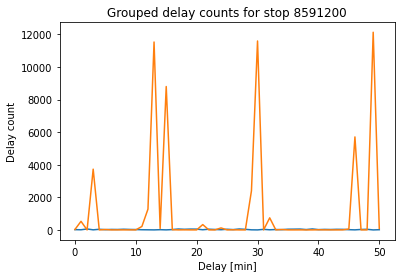

In [83]:
%%local
import matplotlib.pyplot as plt
plt.plot(validation_hist)
plt.xlabel('Delay [min]')
plt.ylabel('Delay count')
plt.title('Grouped delay counts for stop 8591200')

We can certainly see that this delay count distribution shows a pattern, with delay clusters around $\approx$ 13min, 30min and 49min. The assumption that it resembles a normal distribution was partly confirmed around the cluster centres.

**Aggregation method**

In [67]:
#High delay stops
distribution_df.sort(distribution_df.mean_minute_delay.desc()).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+--------------+--------------------+------------------+------------------+------------+
|stop_id|arrival_hour|transport_type|arr_time_prog_status| mean_minute_delay|  std_minute_delay|values_count|
+-------+------------+--------------+--------------------+------------------+------------------+------------+
|8503057|          13|           Zug|            PROGNOSE|              26.0| 35.35533905932738|           2|
|8578679|          17|           Bus|            PROGNOSE|11.967391304347826| 6.213157055189497|          92|
|8578679|          16|           Bus|            PROGNOSE|             10.24|6.3795280686253255|          75|
|8503097|          17|           Zug|            PROGNOSE|              10.0|18.624953392931992|          10|
|8578679|           8|           Bus|            PROGNOSE| 8.552238805970148| 7.693530501562419|          67|
|8578679|          12|           Bus|            PROGNOSE| 8.472222222222221|7.3157599938728115|          72|
|8503091| 

In [78]:
#Low delay stops
distribution_df.where((distribution_df.mean_minute_delay > 0) & (distribution_df.mean_minute_delay < 1)).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+--------------+--------------------+-------------------+------------------+------------+
|stop_id|arrival_hour|transport_type|arr_time_prog_status|  mean_minute_delay|  std_minute_delay|values_count|
+-------+------------+--------------+--------------------+-------------------+------------------+------------+
|8500926|           7|           Bus|            PROGNOSE| 0.9601873536299765|1.7025759292522575|         854|
|8500926|           8|           Bus|            PROGNOSE| 0.7890345649582837|1.7687485692405442|         839|
|8500926|           9|           Bus|            PROGNOSE| 0.8143646408839779|1.3972211912061134|         905|
|8502268|           7|           Zug|                REAL| 0.8662959381044487|1.1519461114641933|        4136|
|8502268|           7|           Zug|          GESCHAETZT|               0.68|0.8889850752826973|         850|
|8502268|           8|           Zug|          GESCHAETZT| 0.6886792452830188|0.8158779401170727|         848|
|

Why did we aggregate based on stops and time? Delay distribution on stops can be very different, for example Würenlos, Bettlen (a high delay stop) and Zürich, Auzelg, and they can also differ based on time (rush hours vs. casual hours).
A similar grouping on time for this problematic was proposed in the paper: https://ieeexplore.ieee.org/document/7313363

For the validation of the aggregation method, we chose to compare the means of two stops (Würenlos, Bettlen and Zürich, Auzelg). Furthermore, we also show the delay means on 2 different hours (rush hour vs. casual hour) of a stop (Zürich, Auzelg).

In [55]:
auzelg = distribution_df.where(distribution_df.stop_id == 8591049).select(f.mean('mean_minute_delay').alias('mean'))
auzelg.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|              mean|
+------------------+
|0.7245436093448266|
+------------------+

In [66]:
wuerenlos = distribution_df.where(distribution_df.stop_id == 8578679).select(f.mean('mean_minute_delay').alias('mean'))
wuerenlos.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|             mean|
+-----------------+
|6.323457067954561|
+-----------------+

In [134]:
auzelg_8AM = distribution_df.where((distribution_df.stop_id == 8591049) & (distribution_df.arrival_hour == 8))\
.select(f.mean('mean_minute_delay').alias('mean'))
auzelg_8AM.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|              mean|
+------------------+
|0.6706638717778546|
+------------------+

In [136]:
auzelg_11AM = distribution_df.where((distribution_df.stop_id == 8591049) & (distribution_df.arrival_hour == 11))\
.select(f.mean('mean_minute_delay').alias('mean'))
auzelg_11AM.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|              mean|
+------------------+
|0.5940616357171079|
+------------------+

As we can see, the mean delay for the stop 8591049 varies from hour to hour, which is why a grouping by hour makes sense.

**Route Certainty calculation** 

(According to the simplifying assumption) Independent delays on stops in a route lead to independent certainty rates on the stops, therefore it is valid to calculate the whole route certainty by mulitplying the stop certainties along the way. Each certainty is an independent event, with a calculation of the certainty of 2 consecutive events (stops) is calculated by $P( X_{i} \land X_{i+1}) \ =\ P( X_{i}) \ *\ P( X_{i+1})$, where $P( X_{i})$ denotes the certainty of a stop.

**Route certainties of low/high delay risk trips**

Does our route certainty calculation make sense? In order to check this, we select two trips, one that starts and ends on low mean delay stops, and another that starts and ends on high mean delay stops. The assumption here is that the low delay trip should have a higher route certainty than the high delay one. In the low delay trip, we start in 8502268 and end in 8500926, see sorted df above. In the high delay trip, we start in 8503057 and end in 8503091. We start at 12:30 and set the certainty level low (0.5), so that we do not filter out some interesting routes.

In [70]:
#Low delay trip
low_delay = route_plan_help('8502268','8500926','12:30:00', 0.5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
#High delay trip
high_delay = route_plan_help('8503057','8503091','12:30:00', 0.5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
#Compare certainty means of all routes of high/low delay trips
low_delay['route_probability'].mean()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9999999999968393

In [92]:
high_delay['route_probability'].mean()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.7261225060612587

The results confirm our assumption that trips with high delay stops lead to lower certainty levels than trips with low delay stops, which is reasonable.

## Discussion

**Strengths**:

+ Our implementation meets all required constraints. It optimizes the travel time for given endpoints and searches only for routes that are on graph. Furthermore, it filters for routes in given certainty intervall and sorts the routes by minimal travel time and maximal departure time.

+ The approach is easy to understand and was used in a similar way in academic publications. Also, the results look reasonable for
many randomized tests we have done.

+ The algorithm has for now a surprisingly good performance, with a mean execution time of $\approx$ 3min.

+ The modular approach and availability of actual data gives the potential to scale up to other metropolitan areas of Switzerland, like Lausanne or Bern.

+ We penalize the number of transfers on a route, which improves the users travel experience, if he chooses to take the recommended route.

**Weaknesses:**

- The chosen aggregation provides a good method to get a sense on how the delays are distributed under different conditions. However, the reduced dimensionality also reduces the precision of  probability calculations, as certain important parameters (dimensions) are aggregated. This is the effect known as *curse of dimensionality*.

- The usage of pyspark sql only commands, and the dispense of hdfs3, proves to be somewhat irritating, as all of the df and functions need to be defined again.

- Our implementation does not work on some stops, which do not have enough time data.

- The creation of the connected stop graph is rather complex and could be done in a neater way.

**What's next**:

+ Improve the route probability calculation. This can be done in various ways. For example, we could increase the dimensionality by 
looking at the transportation type of a trip, or looking at how the arrival/departure times were calculated. 
We have the grouping for that already. Another improvement measure would be to integrate new data sets that correlate with the actual SBB
data, for example weather data, data on some big events in the city or data from users.

+ Make the tool more user friendly, by incorporating trip visualization on a map and making the route plan df more structured.

+ Expanding the tool to other areas of Switzerland. Since we have the  SBB data for all of Switzerland and the methods are reproducible, 
we can incorporate other city areas like Lausanne or Bern.

# Summary

We have sucessfully implemented a stochastic route planning algorithm for the Zürich area. Our implementation relies on the methodological part on the usage of inferential statistics and a modified version of n-path Djikstra. The algorithm meets all of the requested constraints and gives reasonable results. Some parts of our implementation are not optimal, such as the user interface and the certainty precision. However, this can be solved by our proposed next steps. The implementation is particularly useful as it can be expanded to other metropolitan areas of Switzerland.

## Distribution of work

-*Adam* has mostly focused on the methodological part, did literature research on stochastic route planning and n-shortest path algorithms.
He  implemented the `route_probability` function and helper functions. He also worked on the Validation and Discussion part.

-*Yuan* implemented the connected graph creation (function and classes needed for that) and the shortest path algorithm (function and classes needed for that). She helped in the implementation of the predictive model, namely the creation of `distribution_df`.

-*Vera* did the data wrangling and modelled the transportation network, from the data filtering to the definition of a timetable.
She also helped with the `route_probability` function.

-*Matthieu* helped *Vera* with the data wrangling and implemented the function `calc_proba`. He also helped with the calculation of 
delay distributions in the predictive modelling part.

## References

[1] Peng Ni ; Hoang Tam Vo ; Daniel Dahlmeier ; Wentong Cai ; Jordan Ivanchev ; Heiko Aydt,
DEPART: Dynamic Route Planning in Stochastic Time-Dependent Public Transit Networks, https://ieeexplore.ieee.org/document/7313363

[2]Jin Y. Yen: Finding the K Shortest Loopless Paths in a Network,
https://www.semanticscholar.org/paper/Finding-the-K-Shortest-Loopless-Paths-in-a-Network-Yen-YENt/aa6a64afc25f48ad44e510d0055405836c8cc325    

[3] Yen algorithm in Python: https://github.com/handloomweaver/YenKSP/blob/master/algorithms.py

[4]Adi Botea, Evdokia Nikolova, Michele Berlingerio, "Multi-Modal Journey Planning in the Presence of Uncertainty". 
ICAPS 2013.

## User Interface

Creates a user  interface where a user can enter his query, consisting of the `source_node`, the `end_node`, the desired `arrival_time` and the `certainty` that the user wants. The interface isn't working at the moment as we haven't been able to figure out how to combine spark and the following local cells. However, the idea is to call the `route_plan_help` function from the `find_trip`  function, with the given user input.


In [85]:
%%local
import ipywidgets as widgets
import datetime

In [86]:
%%local
#get_ipython().run_cell_magic('spark', '', '%%local

# Function to search for the journey
def find_trip(start, end, arr, perc):
    
    # Check if input values are in the correct format
    try:
        
        float(perc)
        date_time_str = '2018-06-29 ' + arr
        arr_time = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M')
        
    
    except ValueError:
        print('Input values are not in the correct format.\n')
        return
        
    # Check further that the input is correct
    if ((start != end) 
        & ((float(perc) > 0) & (float(perc) <= 1))):
        
        print('Results for the trip:', start, '(Zürich HB) to', end,'(Zürich, Auzelg) arriving at', arr_time.time(), 
              'with a route sucess probability of at least', int(float(perc)*100), '%\n')
        
        route_plan_help(start, end, arr, perc, k=30)
        
        print('MVAY - always on time')
        
    else:
        print('Input values are not in the correct format.\n')#'
                            # )
        

In [87]:
%%local
import a_star_helpers, graph_helpers
# Set styling for widgets
text_style = {'description_width': '40%'}
text_layout = widgets.Layout(width='95%')
button_layout = widgets.Layout(margin='20px 0 0 35%', width='30%')

text_box_layout = widgets.Layout(width='100%', display='flex', flex_flow='column', align_items='stretch')
big_box_layout = widgets.Layout(display='flex',flex_flow='column', align_items='center', 
                                width='60%', border='solid', padding='5%')

# Create the widget elements
start_ID = widgets.Text(description='Starting point\'s stop ID:', 
                        placeholder='8503000', 
                        layout=text_layout, style=text_style)
end_ID = widgets.Text(description='Ending point\'s stop ID:', 
                      placeholder='8591049', 
                      layout=text_layout, style=text_style)
arr_time = widgets.Text(description='Desired arrival time:', 
                        placeholder='12:00', 
                        layout=text_layout, style=text_style)
uncertainty = widgets.Text(description='Route sucess probability:', 
                           placeholder='0.8', 
                           layout=text_layout, style=text_style)
button = widgets.Button(description='Find trip', layout=button_layout)

# Create boxes for formatting
text_box = widgets.Box(children=[start_ID, end_ID, arr_time, uncertainty], layout=text_box_layout)
big_box = widgets.Box(children=[text_box, button], layout=big_box_layout)

In [88]:
%%local

print('\n')
display(big_box)

# Create output in order to be able to show results
print('\n')
out = widgets.Output()
display(out)

# Call find_trip when button is clicked and reset text boxes
@out.capture()
def on_button_click(self):
    find_trip(start_ID.value, end_ID.value, arr_time.value, uncertainty.value)
    start_ID.value = ''
    end_ID.value = ''
    arr_time.value = ''
    uncertainty.value = ''

button.on_click(on_button_click)

Box(children=(Box(children=(Text(value='', description="Starting point's stop ID:", layout=Layout(width='95%')…

Output()

In [61]:
#Example output from the user interface

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----------------+--------------+------------------+----------------------------+----------------+---------------------+
|     | arrival_time   | stop_id      | departure_time   | trip_id                    |   route_number |   route_probability |
|-----+----------------+--------------+------------------+----------------------------+----------------+---------------------|
|   0 | Starts Walking | 8503000:0:9  | 11:53:00         | Walking transfer           |              0 |            0.95695  |
|   1 | 11:54:00       | 8591379      | 11:54:00         | 880.TA.26-14-A-j19-1.10.R  |              0 |            0.95695  |
|   2 | 11:55:00       | 8591071      | 11:55:00         | 880.TA.26-14-A-j19-1.10.R  |              0 |            0.95695  |
|   3 | 11:56:00       | 8591237      | 11:58:00         | Walking transfer           |              0 |            0.95695  |
|   4 | 11:59:00       | 8591339      | 11:59:00         | 550.TA.26-33-B-j19-1.3.H   |              0 |       

In [57]:
rr_df.arrival_time.replace({'01:00:00': 'Starts Walking'}, inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [179]:
r_df.arrival_time.replace({'Trip Start':'Walk Start'}, inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
rr_df.drop(['certainty', 'walking'], axis=1, inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…